In [ ]:
import random
import os, pathlib, shutil, glob
import matplotlib.pyplot as plt

import numpy as np
import torch

import torchvision
from torchvision import transforms
from PIL import Image

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split



import cv2

import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mtdgs4253","key":"db1846381b4ea2855f2e3341be43b11f"}'}

In [ ]:
#Create "~/.kaggle" directory
!mkdir ~/.kaggle

#Move "kaggle.json" file to this directory
!mv kaggle.json ~/.kaggle/

#Change the file access rights to the current user only
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download the dataset with API command
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
100% 3.09G/3.10G [00:17<00:00, 228MB/s]
100% 3.10G/3.10G [00:17<00:00, 188MB/s]


In [ ]:
!ls

breast-histopathology-images.zip  sample_data


In [ ]:
!mkdir dataset

In [ ]:
!ls

breast-histopathology-images.zip  dataset  sample_data


In [ ]:
!unzip -qq "/content/breast-histopathology-images.zip" -d "/content/dataset"

In [ ]:
!ls

breast-histopathology-images.zip  dataset  sample_data


# Preprocess

Create a small dataset from 10% of all the data, and split into
* Training
* Testing

Folder structure for this small dataset

- small dataset

  - training

    - 0

    - 1

  - testing

    - 0

    - 1



In [ ]:
!mkdir small_dataset

In [ ]:
dirs = os.listdir("/content/dataset/")
print("Total number of directories are =",len(dirs))

Total number of directories are = 280


In [ ]:
dirs.remove("IDC_regular_ps50_idx5")
print(print("Total number of directories are =",len(dirs)))

Total number of directories are = 279
None


In [ ]:
# get 10% of all directories
random.shuffle(dirs)
small_dirs = dirs[:int(len(dirs) * 0.1)]

print("Total number of directories for small dataset is = ", len(small_dirs))

Total number of directories for small dataset is =  27


In [ ]:
"""
This function returns two lists containing the paths
of all the images of class 0 and class 1.
"""

def get_image_path_list(dirs):
    #Create empty lists to store the paths of class 0 and class 1 images
    class_0 = []
    class_1 = []
    for dir in dirs:
        #Read class 0 and class 1 images' paths for a given patient
        # and store them it their respective list
        c_0 = glob.glob(f"/content/dataset/{dir}/0/*.png")
        c_1 = glob.glob(f"/content/dataset/{dir}/1/*.png")

        random.shuffle(c_0),random.shuffle(c_0)
        random.shuffle(c_1),random.shuffle(c_1)

        #Add the class 0 and class 1 images' paths for a given patient
        # to the main list
        class_0.extend(c_0)
        class_1.extend(c_1)

        random.shuffle(class_0),random.shuffle(class_0)
        random.shuffle(class_1),random.shuffle(class_1)

    #Shuffle the paths lists randomly
    random.shuffle(class_0), random.shuffle(class_0)
    random.shuffle(class_1), random.shuffle(class_1)

    #Return the class_0 and class_1 lists
    return class_0, class_1



In [ ]:
"""
This function takes the list of directories of patients and move their data to
the small_dataset folder. We will later load them using PyTorch's DataLoader
and use the built-in train-test split function.
"""

def create_dataset(dirs):
    #Use the "get_image_path_list" function to get two separate lists
    # of all the images of class 0 and class 1
    class0, class1 = get_image_path_list(dirs)

    #Shuffle the paths lists randomly
    random.shuffle(class0), random.shuffle(class0)
    random.shuffle(class1), random.shuffle(class1)

    total_img0 = len(class0)
    total_img1 = len(class1)

    #Create sub-directories
    dir_0 = "/content/small_dataset/0"
    dir_1 = "/content/small_dataset/1"
    os.makedirs(dir_0)
    os.mkdir(dir_1)

    #Let's copy the image of class 0
    for i in range(total_img0):
        path = class0[i]
        shutil.copy(src=path, dst= dir_0)

    for i in range(total_img1):
        path = class1[i]
        shutil.copy(src=path, dst= dir_1)

In [ ]:
create_dataset(small_dirs)

In [ ]:
create_dataset(small_dirs)

## Load small dataset using PyTorch DataLoader

In [ ]:
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

# Load dataset
dataset = ImageFolder(root="small_dataset", transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check dataset sizes
print(f"Training set: {len(train_dataset)} samples")
print(f"Testing set: {len(test_dataset)} samples")

Training set: 23386 samples
Testing set: 5847 samples


In [ ]:
classes = ('no-cancer', 'cancer')

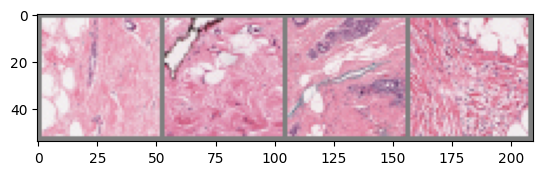

no-cancer  no-cancer  no-cancer  no-cancer 


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:10s}' for j in range(batch_size)))

# Define the Neural Network and training loop

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 81, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Loss function

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 0.433
[1,  4000] loss: 0.375
[2,  2000] loss: 0.334
[2,  4000] loss: 0.334
Finished Training


In [ ]:
PATH = './net1.pth'
torch.save(net.state_dict(), PATH)


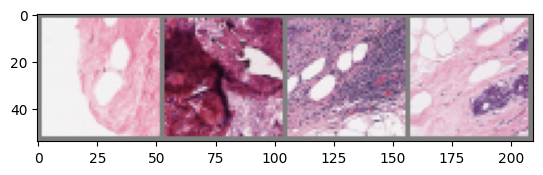

GroundTruth:  no-cancer no-cancer cancer cancer


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [ ]:


outputs = net(images)


In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  no-cancer no-cancer cancer no-cancer


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 86 %


In [ ]:

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pretrained ResNet18 Model
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove last FC layer
resnet.to(device)
resnet.eval()  # Set model to evaluation mode

# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to Extract Features
def extract_features(img_path, model):
    img = cv2.imread(img_path)

    # If the image has an alpha channel (RGBA), convert it to RGB (3 channels)
    if img.shape[2] == 4:
       img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

    # Convert from BGR to RGB (OpenCV loads images in BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    img = transform(img).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        features = model(img)
    return features.squeeze().cpu().numpy().flatten()  # Flatten to 1D vector

# Load Dataset
dataset_path = "/content/dataset/"
dirs = os.listdir(dataset_path)
dirs.remove("IDC_regular_ps50_idx5")

# Select a subset (10% of directories)
random.shuffle(dirs)
small_dirs = dirs[:int(len(dirs) * 0.1)]
print(len(small_dirs))

image_paths = []
features = []
for d in small_dirs:
  images0 = glob.glob(f"/content/dataset/{d}/0/*.png")
  images1 = glob.glob(f"/content/dataset/{d}/1/*.png")

  for img_path in images0:
    image_paths.append(img_path)
    features.append(extract_features(img_path, resnet))

features = np.array(features)
print(f'shape of features: {features.shape}')

# Perform K-Means Clustering
k = 5  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(features)

# Visualize Clustered Images
plt.figure(figsize=(12, 6))
for i in range(k):
    cluster_imgs = [image_paths[j] for j in range(len(labels)) if labels[j] == i]
    plt.subplot(1, k, i + 1)
    img = cv2.imread(cluster_imgs[0], cv2.IMREAD_COLOR)  # Show one image per cluster
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Cluster {i}")
plt.show()

27


KeyboardInterrupt: 

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


27
shape of features: (6945, 512)


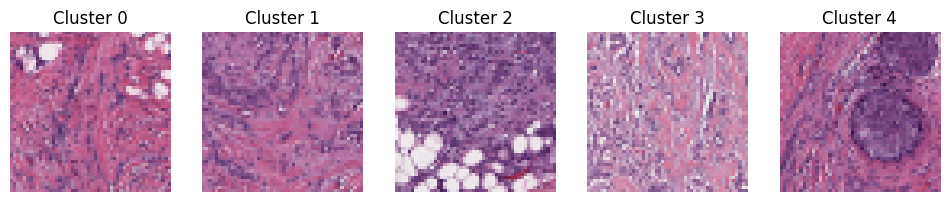

In [ ]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pretrained ResNet18 Model
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove last FC layer
resnet.to(device)
resnet.eval()  # Set model to evaluation mode

# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to Extract Features
def extract_features(img_path, model):
    img = cv2.imread(img_path)

    # If the image has an alpha channel (RGBA), convert it to RGB (3 channels)
    if img.shape[2] == 4:
       img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

    # Convert from BGR to RGB (OpenCV loads images in BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    img = transform(img).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        features = model(img)
    return features.squeeze().cpu().numpy().flatten()  # Flatten to 1D vector

# Load Dataset
dataset_path = "/content/dataset/"
dirs = os.listdir(dataset_path)
dirs.remove("IDC_regular_ps50_idx5")

# Select a subset (10% of directories)
random.shuffle(dirs)
small_dirs = dirs[:int(len(dirs) * 0.1)]
print(len(small_dirs))

image_paths = []
features = []
for d in small_dirs:
  images0 = glob.glob(f"/content/dataset/{d}/0/*.png")
  images1 = glob.glob(f"/content/dataset/{d}/1/*.png")

  for img_path in images1:
    image_paths.append(img_path)
    features.append(extract_features(img_path, resnet))

features = np.array(features)
print(f'shape of features: {features.shape}')

# Perform K-Means Clustering
k = 5  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(features)
# Visualize Clustered Images
plt.figure(figsize=(12, 6))
for i in range(k):
    cluster_imgs = [image_paths[j] for j in range(len(labels)) if labels[j] == i]
    plt.subplot(1, k, i + 1)
    img = cv2.imread(cluster_imgs[0], cv2.IMREAD_COLOR)  # Show one image per cluster
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Cluster {i}")
plt.show()

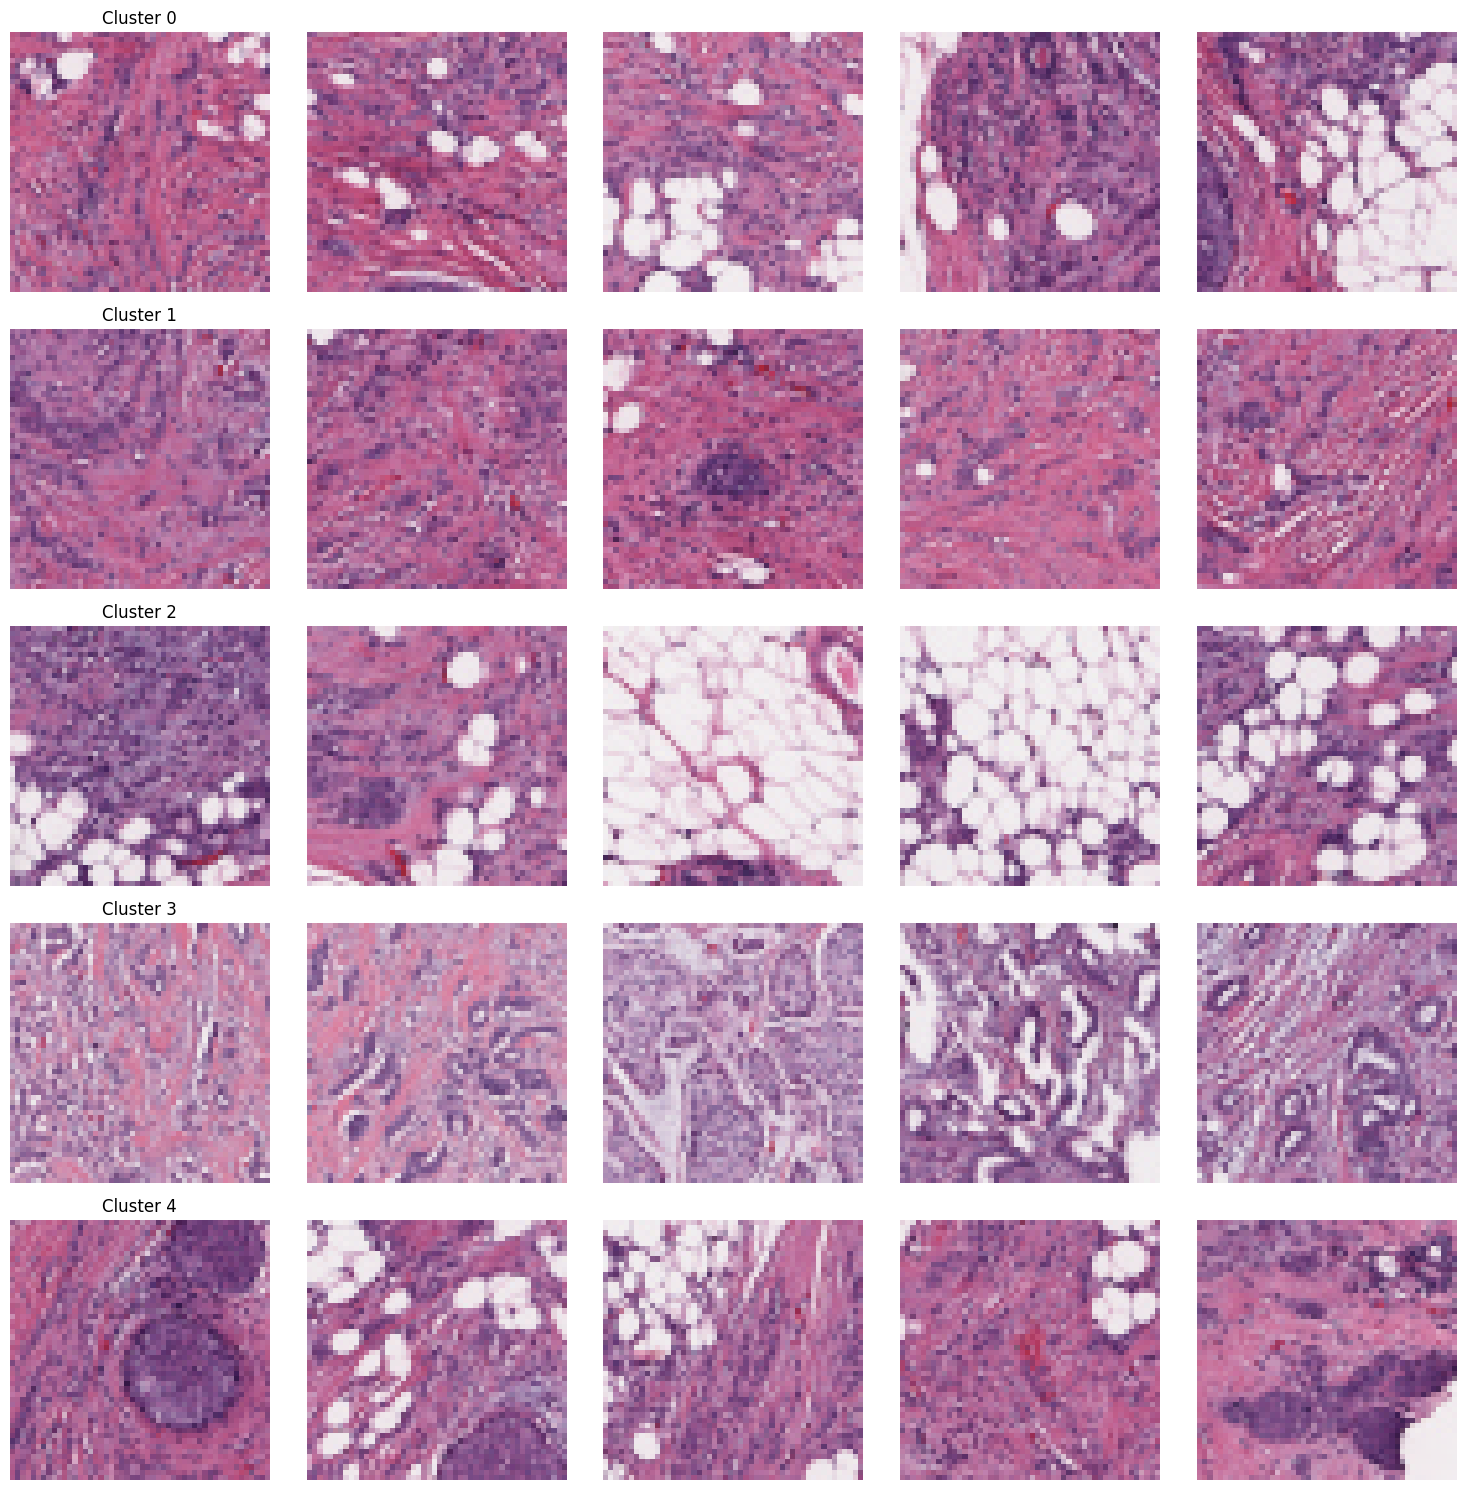

In [ ]:
# Number of images to display per cluster
num_images_per_cluster = 5

# Create a new figure
plt.figure(figsize=(15, k * 3))

for cluster in range(k):
    # Get all image paths belonging to this cluster
    cluster_imgs = [image_paths[i] for i in range(len(labels)) if labels[i] == cluster]

    # Select up to 'num_images_per_cluster' images
    num_to_display = min(num_images_per_cluster, len(cluster_imgs))

    for j in range(num_to_display):
        img_path = cluster_imgs[j]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Create subplot (rows = clusters, columns = num_images_per_cluster)
        plt.subplot(k, num_images_per_cluster, cluster * num_images_per_cluster + j + 1)
        plt.imshow(img)
        plt.axis('off')

        if j == 0:
            plt.title(f"Cluster {cluster}")

plt.tight_layout()
plt.show()
